In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, KFold, learning_curve, validation_curve
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from mlxtend.regressor import StackingCVRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import multiprocessing
import optuna
import cma

plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

In [2]:
m = pd.read_csv("../../data/processed/processed_3.csv")

In [3]:
m

,감독,제작사,배급사,전국 스크린수,전국 관객수,개봉년,국적_기타,국적_독일,국적_러시아,국적_미국,...,장르_어드벤처,장르_전쟁,장르_코미디,장르_판타지,등급_12세이상관람가,등급_15세이상관람가,등급_전체관람가,등급_청소년관람불가,영화구분_독립/예술영화,영화구분_일반영화
0,32994955.0,25901788.0,408568268.0,1587.0,17613682.0,2014,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,20493037.0,16264944.0,408568268.0,1978.0,16264944.0,2019,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,36480785.0,26664001.0,197139226.0,1912.0,14410754.0,2017,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
3,28965892.0,40748216.0,408568268.0,966.0,14245998.0,2014,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,33853565.0,80052717.0,108716317.0,2835.0,13934592.0,2019,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2287,27757.0,5960.0,357074.0,166.0,5960.0,2020,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2288,30209.0,30209.0,126229.0,91.0,6876.0,2021,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2289,3190.0,449249.0,3190.0,65.0,3190.0,2021,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2290,555565.0,458271.0,202280319.0,699.0,360873.0,2021,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [4]:
def recursive_feature_elimination(X, y, model, min_features=1, verbose=True):
    # 초기 변수 개수
    n_features = X.shape[1]
    
    # 현재 변수들의 성능
    best_score = float("inf")
    best_features = X.columns.tolist()
    
    # 최소 변수 개수 이상인 경우
    while n_features > min_features:
        # 모든 변수에 대해 반복
        scores = []
        for feature in X.columns:
            # 선택한 변수 제외
            features = X.columns.drop(feature)
            X_new = X[features]
            
            # 모델 학습 및 평가
            model.fit(X_new, y)
            y_pred = model.predict(X_new)
            score = mean_squared_error(y, y_pred)
            scores.append(score)
            
        # 가장 성능이 좋은 변수 선택
        idx = pd.Index(scores).argmin()
        worst_feature = X.columns[idx]
        
        # 변수 제거
        X.drop(worst_feature, axis=1, inplace=True)
        n_features = X.shape[1]
        if verbose:
            print(f"Removing {worst_feature}: {n_features} features left")
        
        # 모든 변수를 제거한 경우
        if n_features == 0:
            break
        
        # 현재 변수 개수에서의 성능이 최선인 경우
        if min(scores) < best_score:
            best_score = min(scores)
            best_features = X.columns.tolist()
        else:
            break
    
    # 최종 선택된 변수들
    return best_features

In [5]:
# ElasticNetCV 모델 객체 생성
alphas = [0.001, 0.01, 0.1, 1, 10, 100]
enet = ElasticNetCV(alphas=alphas, l1_ratio=0.5, cv=5, max_iter=10000)

# 최소 변수 개수 지정
min_features = 5

# 재귀적 변수 제거 수행
X = m.drop("전국 관객수", axis=1)
y = m["전국 관객수"]
selected_features = recursive_feature_elimination(X, y, enet, min_features=min_features)

# 선택된 변수 출력
print(f"{len(selected_features)} features selected:")
print(selected_features)

Removing 장르_전쟁: 41 features left
Removing 국적_프랑스: 40 features left
41 features selected:
['감독', '제작사', '배급사', '전국 스크린수', '개봉년', '국적_기타', '국적_독일', '국적_러시아', '국적_미국', '국적_스페인', '국적_영국', '국적_일본', '국적_중국', '국적_캐나다', '국적_프랑스', '국적_한국', '장르_SF', '장르_가족', '장르_공연', '장르_공포(호러)', '장르_기타', '장르_다큐멘터리', '장르_드라마', '장르_멜로/로맨스', '장르_뮤지컬', '장르_미스터리', '장르_범죄', '장르_사극', '장르_서부극(웨스턴)', '장르_스릴러', '장르_애니메이션', '장르_액션', '장르_어드벤처', '장르_코미디', '장르_판타지', '등급_12세이상관람가', '등급_15세이상관람가', '등급_전체관람가', '등급_청소년관람불가', '영화구분_독립/예술영화', '영화구분_일반영화']


In [6]:
# 데이터 분할
X = m[selected_features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [7]:
# RandomForestRegressor 모델 학습
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

# RandomForestRegressor 모델 예측
rf_y_pred = rf.predict(X_test)

# 평가지표 계산
rmse = mean_squared_error(y_test, rf_y_pred, squared=False)
mae = mean_absolute_error(y_test, rf_y_pred)
r2 = r2_score(y_test, rf_y_pred)

# 평가지표 출력
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

RMSE: 714387.7709360154
MAE: 282635.2550188954
R-squared: 0.8269571213553658


In [8]:
def plot_learning_curve(model, X, y, cv=5, scoring="r2"):
    # 학습곡선 계산
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=cv, scoring=scoring,
                                                            train_sizes=np.linspace(0.1, 1.0, 10))

    # 트레이닝, 크로스벨리데이션 평균 계산
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)

    # 학습곡선 시각화
    plt.plot(train_sizes, train_mean, label="트레이닝 점수")
    plt.plot(train_sizes, test_mean, label="검증 점수")
    plt.title(f"{type(model).__name__} 학습곡선")
    plt.xlabel("학습 데이터 수")
    plt.ylabel("성능 점수")
    plt.legend()
    plt.show()

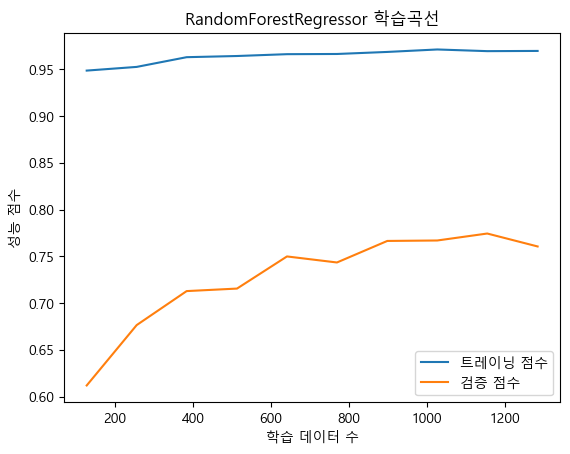

In [9]:
# 학습곡선 그리기
plot_learning_curve(rf, X_train, y_train)

In [10]:
# GradientBoostingRegressor 모델 학습
gb = GradientBoostingRegressor(random_state=42)
gb.fit(X_train, y_train)

# GradientBoostingRegressor 모델 예측
gb_y_pred = gb.predict(X_test)

# 평가지표 계산
rmse = mean_squared_error(y_test, gb_y_pred, squared=False)
mae = mean_absolute_error(y_test, gb_y_pred)
r2 = r2_score(y_test, gb_y_pred)

# 평가지표 출력
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

RMSE: 789027.3711151372
MAE: 370771.59640900476
R-squared: 0.7889089374226154


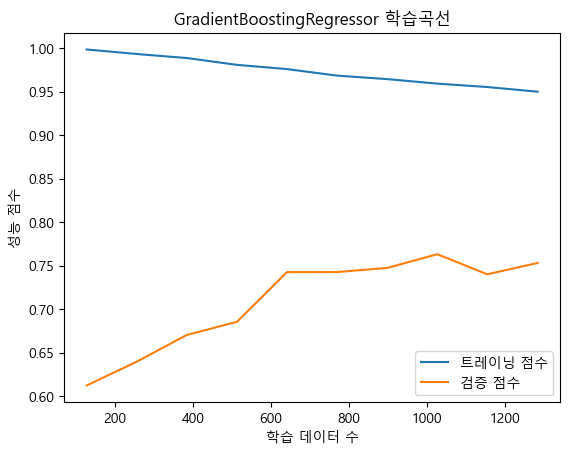

In [11]:
# 학습곡선 그리기
plot_learning_curve(gb, X_train, y_train)

In [12]:
# XGBRegressor 모델 학습
xgb = XGBRegressor(random_state=42)
xgb.fit(X_train, y_train)

# XGBRegressor 모델 예측
xgb_y_pred = xgb.predict(X_test)

# 평가지표 계산
rmse = mean_squared_error(y_test, xgb_y_pred, squared=False)
mae = mean_absolute_error(y_test, xgb_y_pred)
r2 = r2_score(y_test, xgb_y_pred)

# 평가지표 출력
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

RMSE: 746791.7850843003
MAE: 299637.8896229766
R-squared: 0.810902942083013


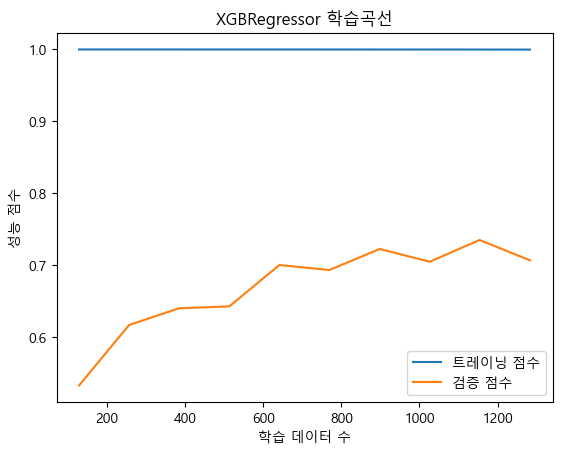

In [13]:
# 학습곡선 그리기
plot_learning_curve(xgb, X_train, y_train)

In [14]:
# LGBMRegressor 모델 학습
lgbm = LGBMRegressor(random_state=42)
lgbm.fit(X_train, y_train)

# LGBMRegressor 모델 예측
lgbm_y_pred = lgbm.predict(X_test)

# 평가지표 계산
rmse = mean_squared_error(y_test, lgbm_y_pred, squared=False)
mae = mean_absolute_error(y_test, lgbm_y_pred)
r2 = r2_score(y_test, lgbm_y_pred)

# 평가지표 출력
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

RMSE: 729075.3390819936
MAE: 299760.6079559894
R-squared: 0.8197685714534738


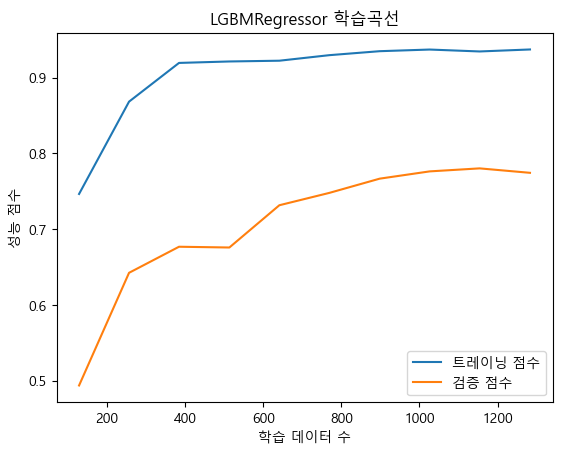

In [15]:
# 학습곡선 그리기
plot_learning_curve(lgbm, X_train, y_train)

In [16]:
# ExtraTreesRegressor 모델 학습
et = ExtraTreesRegressor(random_state=42)
et.fit(X_train, y_train)

# ExtraTreesRegressor 모델 예측
et_y_pred = et.predict(X_test)

# 평가지표 계산
rmse = mean_squared_error(y_test, et_y_pred, squared=False)
mae = mean_absolute_error(y_test, et_y_pred)
r2 = r2_score(y_test, et_y_pred)

# 평가지표 출력
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

RMSE: 761752.3839558195
MAE: 324064.5671947675
R-squared: 0.8032506292302861


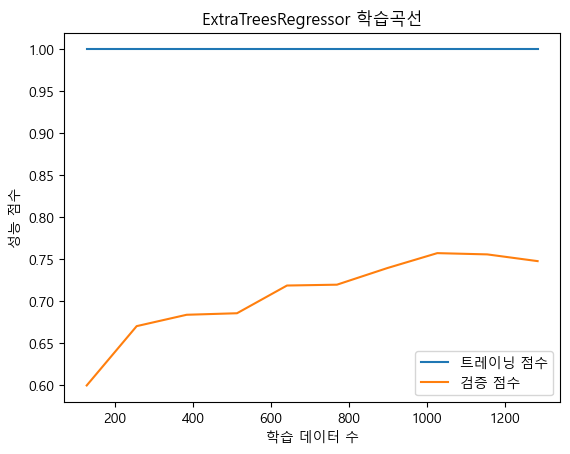

In [17]:
# 학습곡선 그리기
plot_learning_curve(et, X_train, y_train)

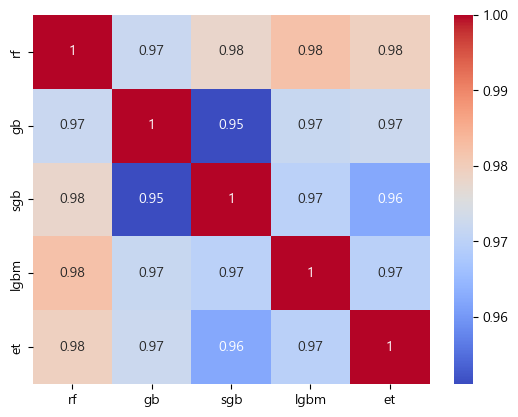

In [18]:
# 각 모델에서 예측한 결과값을 변수로 갖는 데이터프레임 생성
pred_df = pd.DataFrame({
        "rf": rf_y_pred,
        "gb": gb_y_pred,
        "sgb": xgb_y_pred,
        "lgbm": lgbm_y_pred,
        "et" : et_y_pred
    })

# 상관 행렬 계산
corr_matrix = pred_df.corr()

# 시각화
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()

In [19]:
# 메타 모델 선정
models = [rf, gb, xgb, lgbm, et]
best_score = float("-inf")
best_model = None

for model in models:
    score = cross_val_score(model, X_train, y_train, cv=5, scoring="neg_mean_squared_error")
    rmse = (-1 * score.mean()) ** 0.5
    if rmse > best_score:
        best_score = rmse
        best_model = model

print("best_model :", best_model)

# 앙상블 모델 정의
stack = StackingCVRegressor(regressors=(rf, gb, xgb, lgbm, et),
                            meta_regressor=best_model,
                            cv=KFold(n_splits=5, shuffle=True, random_state=42),
                            use_features_in_secondary=True)

# 앙상블 모델 학습
stack.fit(X_train, y_train)

# 앙상블 모델 예측
y_pred = stack.predict(X_test)

# 평가지표 계산
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# 평가지표 출력
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

best_model : XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)
RMSE: 810882.8053457212
MAE: 314642.90846753673
R-squared: 0.7770528675964374


c:\Users\lbw\anaconda3\envs\DACON-AI\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
c:\Users\lbw\anaconda3\envs\DACON-AI\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
c:\Users\lbw\anaconda3\envs\DACON-AI\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but ExtraTreesRegressor was fitted without feature names
  warnings.warn(


c:\Users\lbw\anaconda3\envs\DACON-AI\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
c:\Users\lbw\anaconda3\envs\DACON-AI\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
c:\Users\lbw\anaconda3\envs\DACON-AI\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but ExtraTreesRegressor was fitted without feature names
  warnings.warn(
c:\Users\lbw\anaconda3\envs\DACON-AI\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
c:\Users\lbw\anaconda3\envs\DACON-AI\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
c:\Users\lbw\anaconda3\envs\DACON-AI\Lib\site-packages\sklearn\b

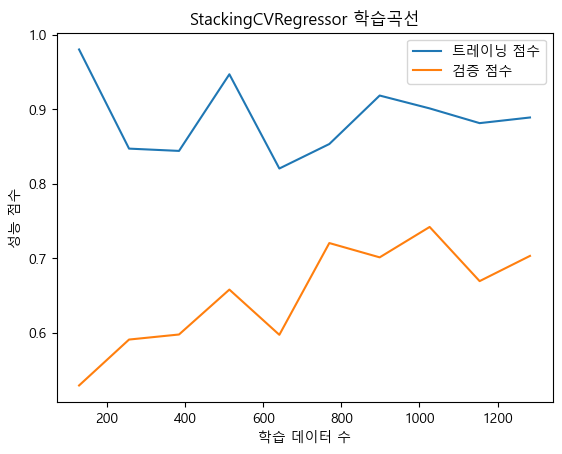

In [20]:
# 학습곡선 그리기
plot_learning_curve(stack, X_train, y_train)

In [21]:
def optimize_model(model_objective, n_trials=100):
    # Bayesian optimization 방식의 하이퍼파라미터 튜닝을 위해 Optuna 라이브러리 사용
    # 최소화를 목적으로 하기 때문에 'minimize'로 설정
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.CmaEsSampler())
    
    # 사용 가능한 모든 CPU 코어 수를 사용하여 병렬 처리
    n_jobs = multiprocessing.cpu_count()  
    
    # 모델 하이퍼파라미터 최적화 실행
    study.optimize(model_objective, n_trials=n_trials, n_jobs=n_jobs)
    
    # 최적 하이퍼파라미터와 그 때의 평가지표 출력
    print(f"Best RMSE: {study.best_value:.4f}")
    print(f"Best Parameters: {study.best_params}")
    
    # 최적 하이퍼파라미터 반환
    return study.best_params

In [22]:
# Random Forest 모델의 하이퍼파라미터 탐색 공간과 목적 함수 정의
def rf_objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 1000, step=100)
    max_depth = trial.suggest_int("max_depth", 3, 10)
    rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    score = cross_val_score(rf, X, y, cv=5, scoring="neg_mean_squared_error")
    rmse = (-1 * score.mean()) ** 0.5
    return rmse

# Random Forest 모델의 하이퍼파라미터 최적화
rf_params = optimize_model(rf_objective)

[I 2023-05-14 15:18:17,417] A new study created in memory with name: no-name-a9b5481b-7d4d-42d8-a283-d1ff129f5263
[I 2023-05-14 15:18:29,177] Trial 10 finished with value: 1946390.988041606 and parameters: {'n_estimators': 200, 'max_depth': 3}. Best is trial 10 with value: 1946390.988041606.
[I 2023-05-14 15:18:52,760] Trial 14 finished with value: 1900552.427839709 and parameters: {'n_estimators': 500, 'max_depth': 4}. Best is trial 14 with value: 1900552.427839709.
[I 2023-05-14 15:18:59,809] Trial 15 finished with value: 1861547.8799692816 and parameters: {'n_estimators': 400, 'max_depth': 7}. Best is trial 15 with value: 1861547.8799692816.
[I 2023-05-14 15:19:00,423] Trial 13 finished with value: 1861547.8799692816 and parameters: {'n_estimators': 400, 'max_depth': 7}. Best is trial 15 with value: 1861547.8799692816.
[I 2023-05-14 15:19:09,164] Trial 3 finished with value: 1946261.736179533 and parameters: {'n_estimators': 900, 'max_depth': 3}. Best is trial 15 with value: 1861547

Best RMSE: 1813040.0450
Best Parameters: {'n_estimators': 400, 'max_depth': 10}


In [23]:
# 최적의 하이퍼 파라미터 적용 후 학습 및 예측
rf.set_params(**rf_params)
rf.fit(X_train, y_train)
rf_y_pred = rf.predict(X_test)

# 평가지표 계산
rmse = mean_squared_error(y_test, rf_y_pred, squared=False)
mae = mean_absolute_error(y_test, rf_y_pred)
r2 = r2_score(y_test, rf_y_pred)

# 평가지표 출력
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

RMSE: 713014.3397702433
MAE: 280513.3490574064
R-squared: 0.8276218416535136


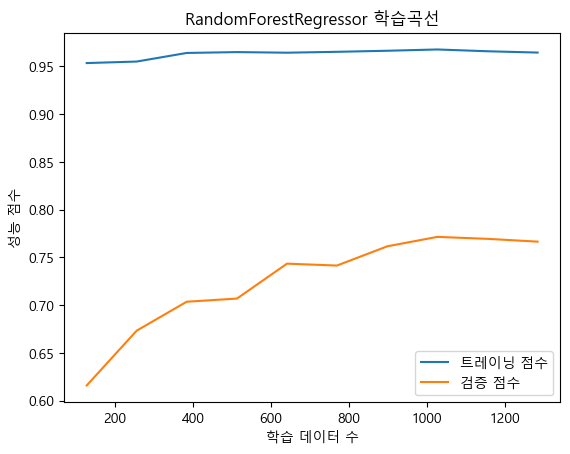

In [24]:
# 학습곡선 그리기
plot_learning_curve(rf, X_train, y_train)

In [25]:
# Gradient Boosting 모델의 하이퍼파라미터 탐색 공간과 목적 함수 정의
def gb_objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 1000, step=100)
    learning_rate = trial.suggest_float("learning_rate", 0.001, 0.1)
    max_depth = trial.suggest_int("max_depth", 3, 10)
    gb = GradientBoostingRegressor(n_estimators=n_estimators, learning_rate=learning_rate,
                                   max_depth=max_depth, random_state=42)
    score = cross_val_score(gb, X, y, cv=5, scoring="neg_mean_squared_error")
    rmse = (-1 * score.mean()) ** 0.5
    return rmse

# Gradient Boosting 모델의 하이퍼파라미터 최적화
gb_params = optimize_model(gb_objective)

[I 2023-05-14 15:26:09,292] A new study created in memory with name: no-name-221ab7e7-ee32-42ad-8f76-4c219f4edf58
[I 2023-05-14 15:26:18,421] Trial 1 finished with value: 1791482.5276373262 and parameters: {'n_estimators': 300, 'learning_rate': 0.06254447613983524, 'max_depth': 3}. Best is trial 1 with value: 1791482.5276373262.
[I 2023-05-14 15:26:40,896] Trial 5 finished with value: 1786277.0029038119 and parameters: {'n_estimators': 500, 'learning_rate': 0.08746569727755509, 'max_depth': 3}. Best is trial 5 with value: 1786277.0029038119.
[I 2023-05-14 15:26:49,217] Trial 13 finished with value: 1787984.922928128 and parameters: {'n_estimators': 400, 'learning_rate': 0.06371688118619118, 'max_depth': 4}. Best is trial 5 with value: 1786277.0029038119.
[I 2023-05-14 15:26:49,387] Trial 2 finished with value: 1790129.2371176225 and parameters: {'n_estimators': 400, 'learning_rate': 0.08171387553610084, 'max_depth': 4}. Best is trial 5 with value: 1786277.0029038119.
[I 2023-05-14 15:2

Best RMSE: 1774677.3808
Best Parameters: {'n_estimators': 600, 'learning_rate': 0.06775029550437586, 'max_depth': 6}


In [26]:
# 최적의 하이퍼 파라미터 적용 후 학습 및 예측
gb.set_params(**gb_params)
gb.fit(X_train, y_train)
gb_y_pred = gb.predict(X_test)

# 평가지표 계산
rmse = mean_squared_error(y_test, gb_y_pred, squared=False)
mae = mean_absolute_error(y_test, gb_y_pred)
r2 = r2_score(y_test, gb_y_pred)

# 평가지표 출력
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

RMSE: 770063.6683240707
MAE: 304605.31355615443
R-squared: 0.798933843760976


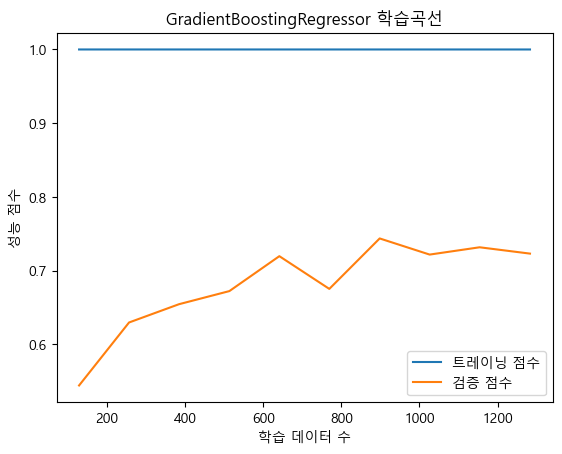

In [27]:
# 학습곡선 그리기
plot_learning_curve(gb, X_train, y_train)

In [28]:
# XGBoost 모델의 하이퍼파라미터 탐색 공간과 목적 함수 정의
def xgb_objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 1000, step=100)
    learning_rate = trial.suggest_float("learning_rate", 0.001, 0.1)
    max_depth = trial.suggest_int("max_depth", 3, 10)
    subsample = trial.suggest_float("subsample", 0.5, 1)
    xgb = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate,
                       max_depth=max_depth, subsample=subsample, random_state=42)
    score = cross_val_score(xgb, X, y, cv=5, scoring="neg_mean_squared_error")
    rmse = (-1 * score.mean()) ** 0.5
    return rmse
    
# XGBoost 모델의 하이퍼파라미터 최적화
xgb_params = optimize_model(xgb_objective)

[I 2023-05-14 15:31:59,645] A new study created in memory with name: no-name-2989bf96-ebb7-48ce-926c-0e4c397b4c5f
[I 2023-05-14 15:32:03,440] Trial 14 finished with value: 1787484.6328677747 and parameters: {'n_estimators': 100, 'learning_rate': 0.05178746809346022, 'max_depth': 5, 'subsample': 0.8381907266540722}. Best is trial 14 with value: 1787484.6328677747.
[I 2023-05-14 15:32:04,437] Trial 15 finished with value: 1783472.736299403 and parameters: {'n_estimators': 100, 'learning_rate': 0.04833860583823397, 'max_depth': 6, 'subsample': 0.5546489042062046}. Best is trial 15 with value: 1783472.736299403.
[I 2023-05-14 15:32:05,548] Trial 0 finished with value: 1782470.9020246218 and parameters: {'n_estimators': 200, 'learning_rate': 0.062404147818034404, 'max_depth': 4, 'subsample': 0.6210039367303242}. Best is trial 0 with value: 1782470.9020246218.
[I 2023-05-14 15:32:07,240] Trial 5 finished with value: 1783821.6491272915 and parameters: {'n_estimators': 200, 'learning_rate': 0.

Best RMSE: 1766646.6948
Best Parameters: {'n_estimators': 700, 'learning_rate': 0.07545166665949148, 'max_depth': 3, 'subsample': 0.6644563642062709}


In [29]:
# 최적의 하이퍼 파라미터 적용 후 학습 및 예측
xgb.set_params(**xgb_params)
xgb.fit(X_train, y_train)
xgb_y_pred = xgb.predict(X_test)

# 평가지표 계산
rmse = mean_squared_error(y_test, xgb_y_pred, squared=False)
mae = mean_absolute_error(y_test, xgb_y_pred)
r2 = r2_score(y_test, xgb_y_pred)

# 평가지표 출력
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

RMSE: 754912.3605447431
MAE: 346434.827518197
R-squared: 0.8067681193619616


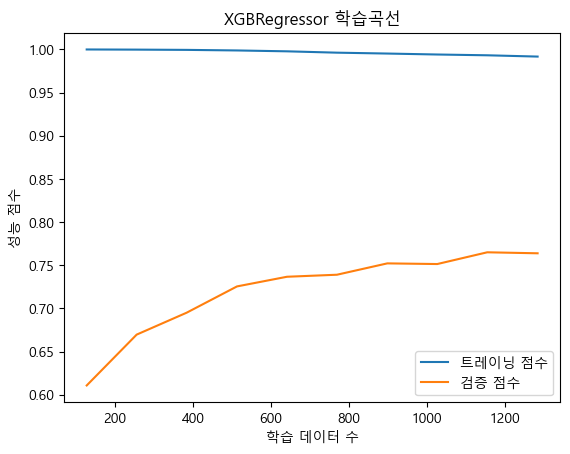

In [30]:
# 학습곡선 그리기
plot_learning_curve(xgb, X_train, y_train)

In [31]:
# LightGBM 모델의 하이퍼파라미터 탐색 공간과 목적 함수 정의
def lgbm_objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 1000, step=100)
    learning_rate = trial.suggest_float("learning_rate", 0.001, 0.1)
    max_depth = trial.suggest_int("max_depth", 3, 10)
    num_leaves = trial.suggest_int("num_leaves", 10, 100)
    lgbm = LGBMRegressor(n_estimators=n_estimators, learning_rate=learning_rate,
    max_depth=max_depth, num_leaves=num_leaves, random_state=42)
    score = cross_val_score(lgbm, X, y, cv=5, scoring="neg_mean_squared_error")
    rmse = (-1 * score.mean()) ** 0.5
    return rmse

# LightGBM 모델의 하이퍼파라미터 최적화
lgbm_params = optimize_model(lgbm_objective)

[I 2023-05-14 15:35:30,296] A new study created in memory with name: no-name-16ee0463-f7ea-4401-b75e-4cf5a6dd4cc1
[I 2023-05-14 15:35:37,181] Trial 6 finished with value: 1776294.3375796734 and parameters: {'n_estimators': 300, 'learning_rate': 0.08679006620088495, 'max_depth': 4, 'num_leaves': 35}. Best is trial 6 with value: 1776294.3375796734.
[I 2023-05-14 15:35:37,736] Trial 12 finished with value: 1782199.7656773974 and parameters: {'n_estimators': 200, 'learning_rate': 0.042922153787863515, 'max_depth': 5, 'num_leaves': 55}. Best is trial 6 with value: 1776294.3375796734.
[I 2023-05-14 15:35:40,320] Trial 3 finished with value: 1773871.2579434782 and parameters: {'n_estimators': 400, 'learning_rate': 0.09945421076897697, 'max_depth': 4, 'num_leaves': 45}. Best is trial 3 with value: 1773871.2579434782.
[I 2023-05-14 15:35:40,815] Trial 13 finished with value: 1902405.4583704674 and parameters: {'n_estimators': 300, 'learning_rate': 0.005029627715064246, 'max_depth': 4, 'num_leav

Best RMSE: 1772483.5897
Best Parameters: {'n_estimators': 600, 'learning_rate': 0.04789900763248313, 'max_depth': 4, 'num_leaves': 64}


In [32]:
# 최적의 하이퍼 파라미터 적용 후 학습 및 예측
lgbm.set_params(**lgbm_params)
lgbm.fit(X_train, y_train)
lgbm_y_pred = lgbm.predict(X_test)

# 평가지표 계산
rmse = mean_squared_error(y_test, lgbm_y_pred, squared=False)
mae = mean_absolute_error(y_test, lgbm_y_pred)
r2 = r2_score(y_test, lgbm_y_pred)

# 평가지표 출력
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

RMSE: 722162.9928080674
MAE: 324167.5575219513
R-squared: 0.8231699105805381


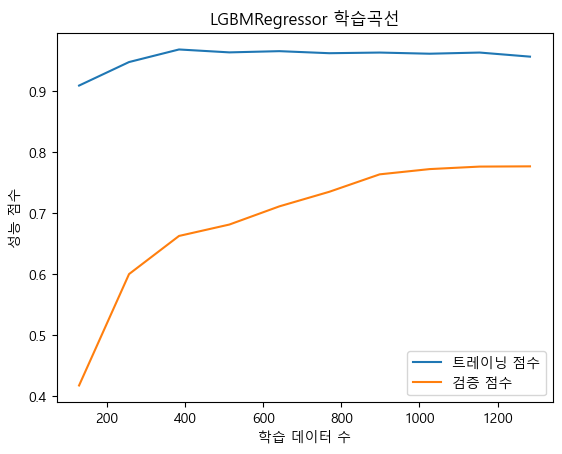

In [33]:
# 학습곡선 그리기
plot_learning_curve(lgbm, X_train, y_train)

In [34]:
# Extra Trees Regressor 모델의 하이퍼파라미터 탐색 공간과 목적 함수 정의
def et_objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 1000, step=100)
    max_depth = trial.suggest_int("max_depth", 3, 10)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    et = ExtraTreesRegressor(n_estimators=n_estimators, max_depth=max_depth, 
                             min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, 
                             random_state=42)
    score = cross_val_score(et, X, y, cv=5, scoring="neg_mean_squared_error")
    rmse = (-1 * score.mean()) ** 0.5
    return rmse

# Extra Trees Regressor 모델의 하이퍼파라미터 최적화
et_params = optimize_model(et_objective)

[I 2023-05-14 15:37:44,080] A new study created in memory with name: no-name-98e69137-e167-4b0b-81c1-c48bd098ef3e
[I 2023-05-14 15:37:52,274] Trial 11 finished with value: 1853112.3444842908 and parameters: {'n_estimators': 100, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 7}. Best is trial 11 with value: 1853112.3444842908.
[I 2023-05-14 15:37:57,356] Trial 10 finished with value: 1866443.0901044358 and parameters: {'n_estimators': 200, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 4}. Best is trial 11 with value: 1853112.3444842908.
[I 2023-05-14 15:37:58,709] Trial 14 finished with value: 1856909.217944303 and parameters: {'n_estimators': 200, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 6}. Best is trial 11 with value: 1853112.3444842908.
[I 2023-05-14 15:38:00,155] Trial 2 finished with value: 1844902.376094492 and parameters: {'n_estimators': 200, 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 7}. Best is trial 2 with value

Best RMSE: 1813929.9934
Best Parameters: {'n_estimators': 500, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 2}


In [35]:
# 최적의 하이퍼 파라미터 적용 후 학습 및 예측
et.set_params(**et_params)
et.fit(X_train, y_train)
et_y_pred = et.predict(X_test)

# 평가지표 계산
rmse = mean_squared_error(y_test, et_y_pred, squared=False)
mae = mean_absolute_error(y_test, et_y_pred)
r2 = r2_score(y_test, et_y_pred)

# 평가지표 출력
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

RMSE: 750173.6231731406
MAE: 329888.32543977443
R-squared: 0.8091864164861969


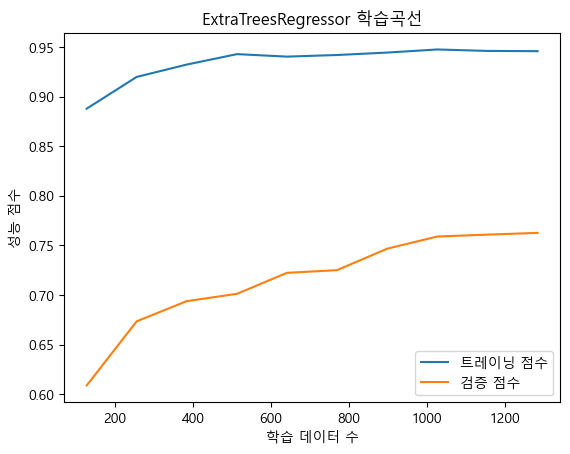

In [36]:
# 학습곡선 그리기
plot_learning_curve(et, X_train, y_train)

In [37]:
# 메타 모델 선정
models = [rf, gb, xgb, lgbm, et]
best_score = float("-inf")
best_model = None

for model in models:
    score = cross_val_score(model, X_train, y_train, cv=5, scoring="neg_mean_squared_error")
    rmse = (-1 * score.mean()) ** 0.5
    if rmse > best_score:
        best_score = rmse
        best_model = model

print("best_model :", best_model)

# 앙상블 모델 정의
stack = StackingCVRegressor(regressors=(rf, gb, xgb, lgbm, et),
                            meta_regressor=best_model,
                            cv=KFold(n_splits=5, shuffle=True, random_state=42),
                            use_features_in_secondary=True)

# 앙상블 모델 학습
stack.fit(X_train, y_train)

# 앙상블 모델 예측
y_pred = stack.predict(X_test)

# 평가지표 계산
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# 평가지표 출력
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

best_model : GradientBoostingRegressor(learning_rate=0.06775029550437586, max_depth=6,
                          n_estimators=600, random_state=42)
RMSE: 726141.2522334047
MAE: 287707.0546738196
R-squared: 0.8212162972411243


c:\Users\lbw\anaconda3\envs\DACON-AI\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
c:\Users\lbw\anaconda3\envs\DACON-AI\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
c:\Users\lbw\anaconda3\envs\DACON-AI\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but ExtraTreesRegressor was fitted without feature names
  warnings.warn(


c:\Users\lbw\anaconda3\envs\DACON-AI\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
c:\Users\lbw\anaconda3\envs\DACON-AI\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
c:\Users\lbw\anaconda3\envs\DACON-AI\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but ExtraTreesRegressor was fitted without feature names
  warnings.warn(
c:\Users\lbw\anaconda3\envs\DACON-AI\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
c:\Users\lbw\anaconda3\envs\DACON-AI\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
c:\Users\lbw\anaconda3\envs\DACON-AI\Lib\site-packages\sklearn\b

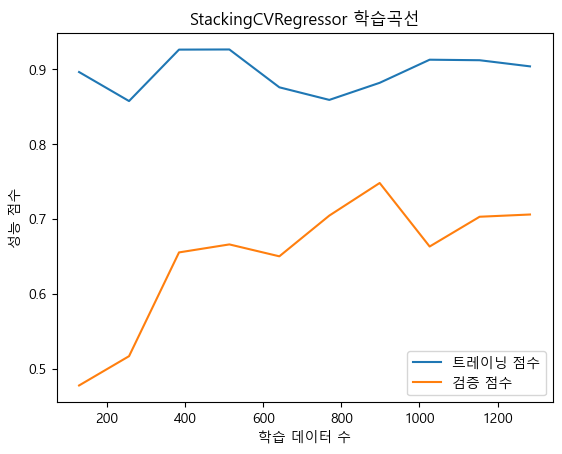

In [38]:
# 학습곡선 그리기
plot_learning_curve(stack, X_train, y_train)